# Kaggle -- blindness

https://www.kaggle.com/c/aptos2019-blindness-detection/overview

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [1]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.callbacks.tracker import *
torch.backends.cudnn.benchmark = True
import time
from fastprogress import fastprogress
from fastai.general_optimizer import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [2]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Get data from kaggle seedling playground

In [ ]:
!kaggle_setup.txt # setup kaggle account

In [4]:
!kaggle competitions download -c aptos2019-blindness-detection

100%|█████████████████████████████████████▉| 7.99G/8.01G [01:55<00:00, 59.8MB/s]
100%|██████████████████████████████████████| 8.01G/8.01G [01:55<00:00, 74.4MB/s]
 98%|██████████████████████████████████████▎| 1.48G/1.50G [00:15<00:00, 142MB/s]
100%|███████████████████████████████████████| 1.50G/1.50G [00:15<00:00, 106MB/s]
  0%|                                               | 0.00/53.7k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 53.7k/53.7k [00:00<00:00, 40.1MB/s]
  0%|                                               | 0.00/24.5k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 24.5k/24.5k [00:00<00:00, 30.4MB/s]
  0%|                                               | 0.00/28.3k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 28.3k/28.3k [00:00<00:00, 37.4MB/s]


## Looking at the data

In [3]:
path = Path('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/')

In [4]:
path.ls()

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/blind-part2.ipynb'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/.ipynb_checkpoints'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train_images.zip'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/sample_submission.csv'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/test.csv'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/blind-part4.ipynb'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/blind-part3.ipynb'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/blind_resnet34_simple_TTA.txt'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/blind.ipynb'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/blind_resnet34_simple.txt'),
 PosixPath('/home/jupyter/tutorials

In [5]:
path_img = path/'train'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In [6]:
fnames_train = get_image_files(path_img)

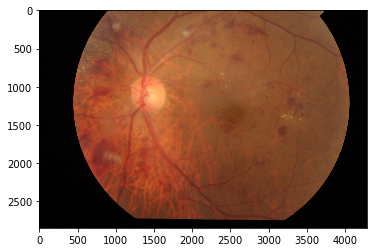

In [7]:
plt.imshow(plt.imread(str(fnames_train[20])))

## use Databunch api

In [8]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [9]:
tfms = get_transforms(do_flip=True)
data = (ImageList.from_df(train_df, path_img, suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(tfms, size=229)
        .databunch()
        .normalize(imagenet_stats))

## Training: mixup and label smoothing (https://forums.fast.ai/t/implement-bag-of-tricks-for-image-classification-with-convolutional-neural-networks/41105)

In [10]:
learn = (Learner(data, models.xresnet34(),
             metrics=error_rate, wd=1e-3,
             bn_wd=False, true_wd=True, loss_func = LabelSmoothingCrossEntropy())
         .mixup(alpha=0.2))

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


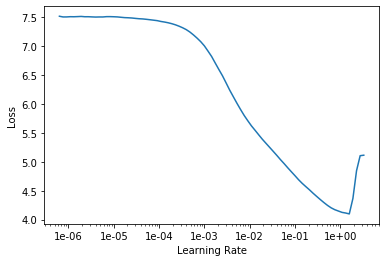

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,2.336113,2.975684,0.486339,02:26
1,2.114611,2.072412,0.359290,02:25
2,2.047128,1.942019,0.334699,02:26
3,1.978645,2.018323,0.445355,02:28
4,1.938228,1.852217,0.338798,02:25


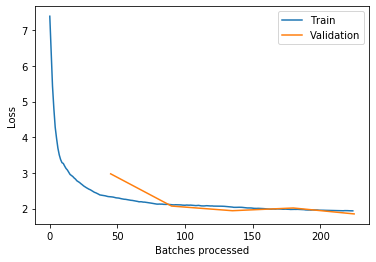

In [14]:
learn.recorder.plot_losses()

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()



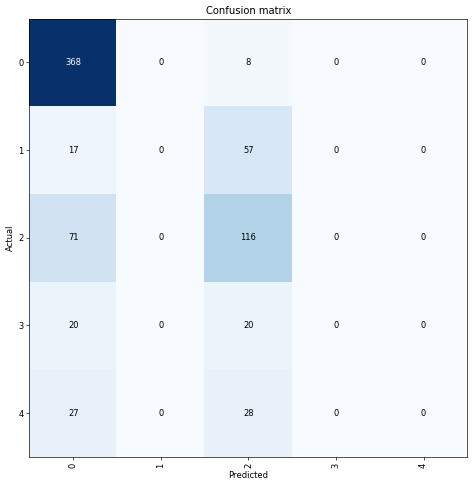

In [16]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

it's not very successful

### Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.882028,1.848321,0.334699,02:26


## Add lr scheduler

In [24]:
lr = 1e-1
epochs = 5
b_its = len(data.train_dl)
bs_rat = bs/256
lr *= bs_rat

ph1 = (TrainingPhase(epochs*0.5*b_its)
            .schedule_hp('lr', (lr/20,lr), anneal=annealing_cos)
            .schedule_hp('eps', (1e-4,1e-7), anneal=annealing_cos)
            )
ph2 = (TrainingPhase(epochs*0.5*b_its)
            .schedule_hp('lr', (lr,lr/1e5), anneal=annealing_cos)
            .schedule_hp('eps', (1e-7,1e-7), anneal=annealing_cos)
            )

learn = (Learner(data, models.xresnet34(),
             metrics=error_rate, wd=1e-3,
             bn_wd=False, true_wd=True, loss_func = LabelSmoothingCrossEntropy())
         .mixup(alpha=0.2))

gs = GeneralScheduler(learn, (ph1,ph2))
learn.fit(epochs, lr=1, callbacks=gs)


epoch,train_loss,valid_loss,error_rate,time
0,2.560106,2.168028,0.374317,02:26
1,2.181561,5.878617,0.478142,02:24
2,2.065204,2.252399,0.403005,02:26
3,1.984790,1.851071,0.311475,02:25
4,1.921212,1.812437,0.306011,02:30


In [25]:
learn.unfreeze()

In [26]:
learn.fit(epochs, lr=0.01, callbacks=gs)

epoch,train_loss,valid_loss,error_rate,time
0,1.874445,2.154169,0.463115,02:26
1,1.902773,3.459856,0.464481,02:30
